<a href="https://colab.research.google.com/github/AshishKhandekar99/Startup-Success-Fail-Dataset-from-Crunchbase/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import itertools

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Load the uploaded dataset
file_path = "/content/drive/MyDrive/big_startup_secsees_dataset.csv"
df = pd.read_csv(file_path)

In [31]:
# Display basic information about the dataset
df_info = df.info()
df_head = df.head()
df_columns = df.columns.tolist()

df_info , df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   permalink          66368 non-null  object
 1   name               66367 non-null  object
 2   homepage_url       61310 non-null  object
 3   category_list      63220 non-null  object
 4   funding_total_usd  66368 non-null  object
 5   status             66368 non-null  object
 6   country_code       59410 non-null  object
 7   state_code         57821 non-null  object
 8   region             58338 non-null  object
 9   city               58340 non-null  object
 10  funding_rounds     66368 non-null  int64 
 11  founded_at         51147 non-null  object
 12  first_funding_at   66344 non-null  object
 13  last_funding_at    66368 non-null  object
dtypes: int64(1), object(13)
memory usage: 7.1+ MB


(None,
        funding_rounds
 count    66368.000000
 mean         1.732522
 std          1.360251
 min          1.000000
 25%          1.000000
 50%          1.000000
 75%          2.000000
 max         19.000000)

In [32]:
# Clean and preprocess key columns for EDA
df_clean = df.copy()

In [33]:
# Replace '-' or missing with NaN in funding
df_clean['funding_total_usd'] = df_clean['funding_total_usd'].replace('-', np.nan)
df_clean['funding_total_usd'] = df_clean['funding_total_usd'].astype(float)

In [34]:
# Drop rows with null status or funding_total_usd
df_clean = df_clean.dropna(subset=['status', 'funding_total_usd'])

In [35]:
# Create a simplified binary success label
# success = 1 if acquired or IPO, fail = 0 if closed, else 'operating' left out for now
df_clean['success_binary'] = df_clean['status'].apply(lambda x: 1 if x.lower() in ['acquired', 'ipo'] else (0 if x.lower() == 'closed' else np.nan))


In [36]:
# Filter only for clear success/failure
df_bin = df_clean.dropna(subset=['success_binary'])

**1. Distribution of Startup Statuses**

This graph shows the distribution of startup statuses. The tallest bar represents "operating," meaning most startups are still running. The next bar is "closed," showing many startups have shut down. The third bar is "acquired," indicating some were bought by other companies. The last bar, "IPO," is the shortest, meaning very few startups went public. Overall, most startups are operating, while few achieve an IPO.

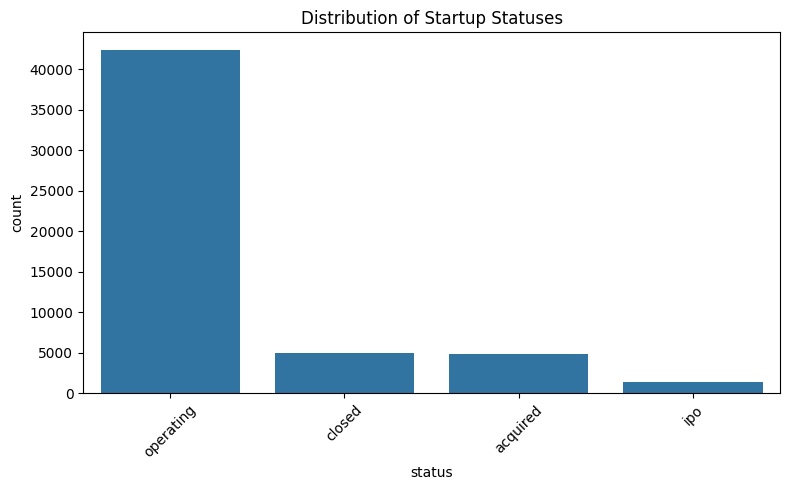

In [37]:
# Plot 1: Distribution of Startup Statuses
plt.figure(figsize=(8, 5))
sns.countplot(data=df_clean, x='status', order=df_clean['status'].value_counts().index)
plt.title('Distribution of Startup Statuses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**2. Funding Distribution**

This graph shows how much funding startups received, focusing on amounts under 50 million.The tallest bar is at "0" USD meaning many startups got no funding. As funding increases, the number of startups drops sharply. Very few startups received between $40-$50 million. In short, most startups get little or no funding, and only a small number secure larger investments.

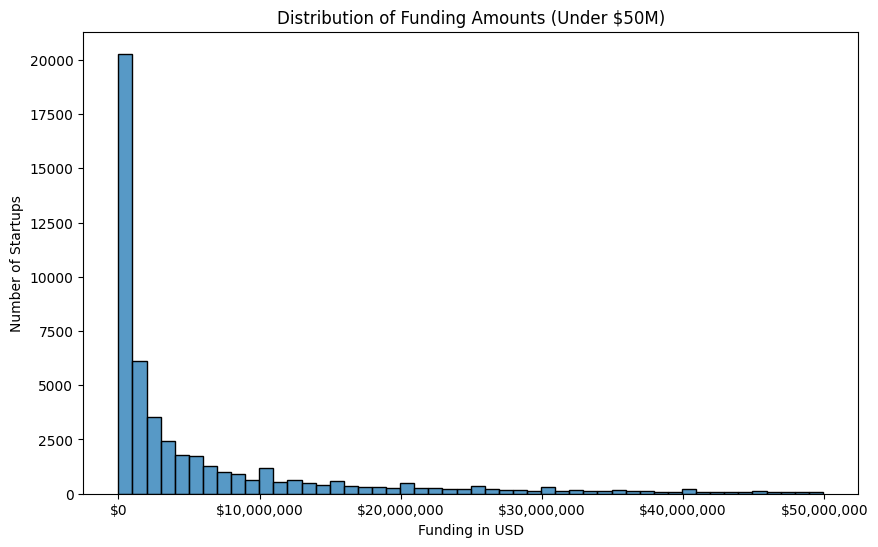

In [38]:
# Temporary conversion just for plotting
# Handle non-numeric values by coercing them to NaN
funding_numeric = pd.to_numeric(df['funding_total_usd'], errors='coerce')
# Filter for values under $50M and drop NaN values
filtered_data = funding_numeric[(funding_numeric < 5e7) & (funding_numeric.notna())]

plt.figure(figsize=(10,6))
sns.histplot(filtered_data, bins=50)
plt.title('Distribution of Funding Amounts (Under $50M)')
plt.xlabel('Funding in USD')
plt.ylabel('Number of Startups')
# Format x-axis to show dollar amounts properly
plt.gca().xaxis.set_major_formatter('${x:,.0f}')
plt.show()

**3. Funding Over Time Analysis**

This graph shows how total startup funding has changed over the years, measured in millions of USD. The funding amounts range from $0 to $100,000 million. The lowest point is around year 2000, indicating less investment in startups at that time. The highest point reaches $100,000 million, showing a big increase in funding in later years. Overall, startup funding has grown significantly over time.

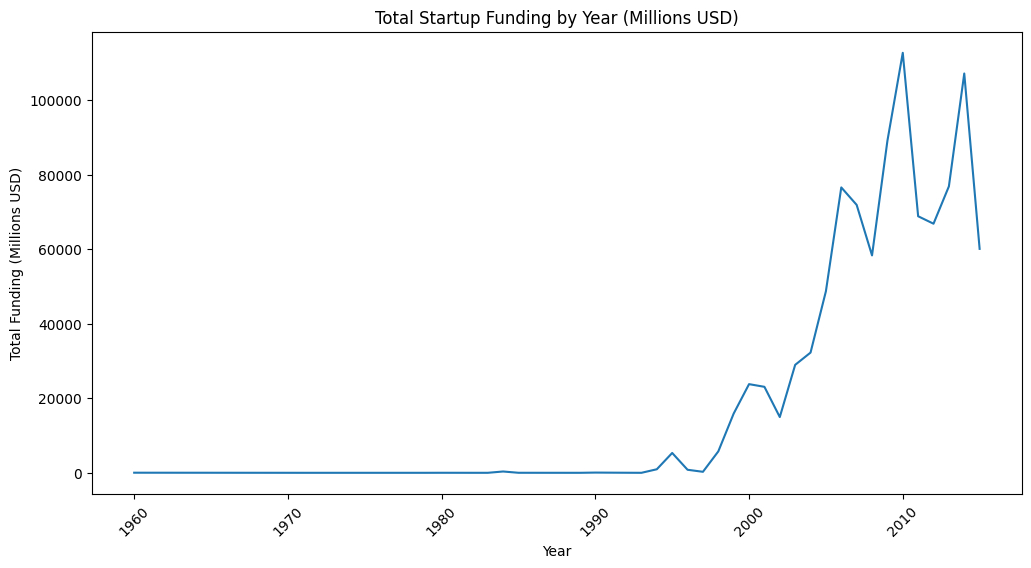

In [39]:
# 1. Convert funding amount to numeric first (to fix the division error)
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')

# 2. Convert dates with error handling
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], errors='coerce')

# 3. Create a clean copy to avoid SettingWithCopyWarning
clean_df = df.copy()

# 4. Add year columns using .loc to avoid warnings
clean_df.loc[:, 'first_funding_year'] = clean_df['first_funding_at'].dt.year
clean_df.loc[:, 'last_funding_year'] = clean_df['last_funding_at'].dt.year

# 5. Filter out invalid dates and funding amounts
valid_data = clean_df[
    (clean_df['first_funding_at'].notna()) &
    (clean_df['last_funding_at'].notna()) &
    (clean_df['funding_total_usd'].notna())
]

# 6. Plot funding trends
plt.figure(figsize=(12,6))
funding_by_year = valid_data.groupby('first_funding_year')['funding_total_usd'].sum()
sns.lineplot(
    x=funding_by_year.index,
    y=funding_by_year.values/1e6  # Now safe to divide since we converted to numeric
)
plt.title('Total Startup Funding by Year (Millions USD)')
plt.xlabel('Year')
plt.ylabel('Total Funding (Millions USD)')
plt.xticks(rotation=45)
plt.show()

**4.Funding Rounds Analysis**

This box plot shows the relationship between the number of funding rounds a startup goes through and its total funding (in USD, using a log scale). The correlation of 0.11 is very weak, meaning there’s almost no link between how many rounds a startup raises and how much total funding it gets. Some startups raise a lot in few rounds, while others raise little over many rounds.

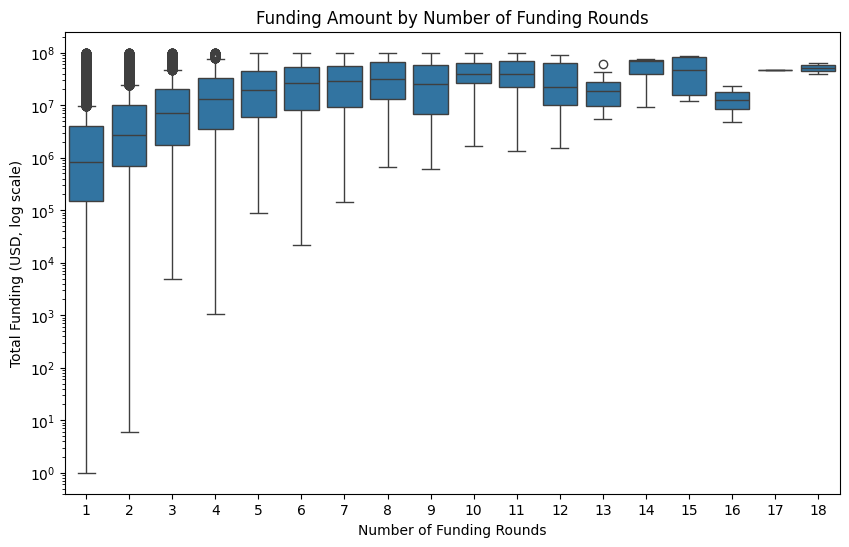

Correlation between funding rounds and total funding: 0.11


In [40]:
# Relationship between funding rounds and total funding
plt.figure(figsize=(10,6))
sns.boxplot(x='funding_rounds', y='funding_total_usd', data=df[df['funding_total_usd'] < 1e8])
plt.yscale('log')
plt.title('Funding Amount by Number of Funding Rounds')
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Total Funding (USD, log scale)')
plt.show()

# Correlation between rounds and funding
print(f"Correlation between funding rounds and total funding: {df['funding_rounds'].corr(df['funding_total_usd']):.2f}")

**5. Top Categories**

This bar graph ranks the top 10 startup categories by the number of startups in each. "Software" has the highest count (likely near 8000), making it the most popular category. Mobile, Biotechnology, and E-Commerce follow closely. Less common categories like Games and Advertising appear at the bottom. The graph shows that tech-focused fields dominate, with Software and Mobile leading the startup landscape.

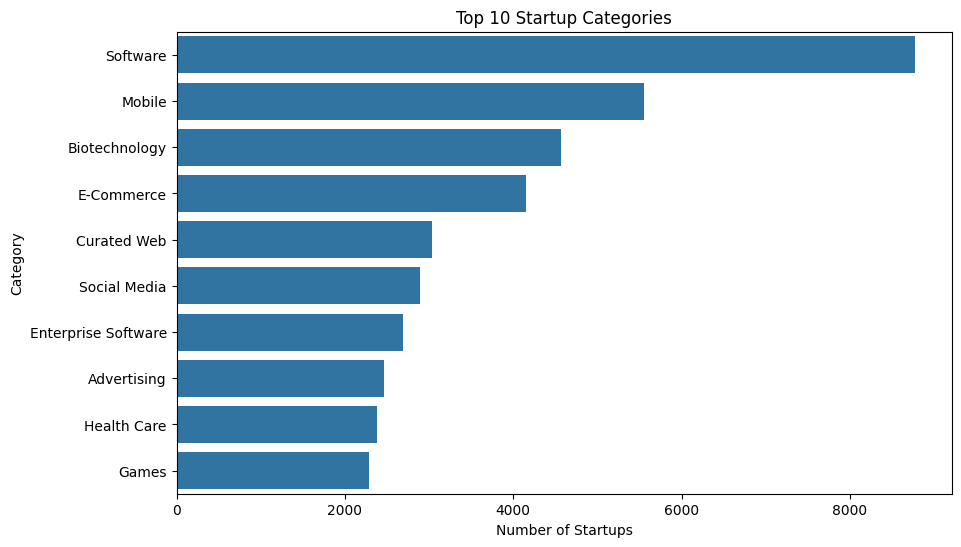

In [41]:
# Split category lists and count occurrences
all_categories = list(itertools.chain(*df['category_list'].str.split('|').dropna()))
top_categories = pd.Series(Counter(all_categories)).sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Top 10 Startup Categories')
plt.xlabel('Number of Startups')
plt.ylabel('Category')
plt.show()

**6.Category Funding Analysis**

This bar graph shows the top 10 highest-funded startup categories based on average funding in millions of USD. "Limousines" leads with the highest average funding (likely near 800 million), followed by niche sectors like Space Travel and B2B Express Delivery. The graph highlights that capital-intensive industries—such as Space Travel and Solar Power—tend to secure much larger investments compared to typical tech startups.

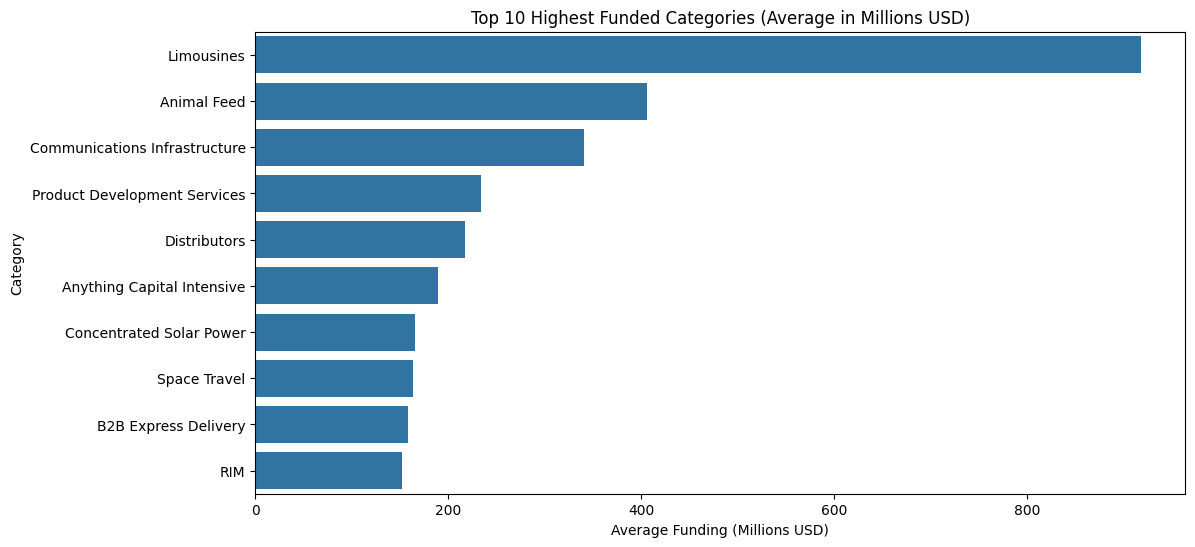

In [42]:
# Calculate average funding by category
category_funding = {}
for category in set(all_categories):
    mask = df['category_list'].str.contains(category, na=False)
    category_funding[category] = df[mask]['funding_total_usd'].mean()

top_funded_categories = pd.Series(category_funding).sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_funded_categories.values/1e6, y=top_funded_categories.index)
plt.title('Top 10 Highest Funded Categories (Average in Millions USD)')
plt.xlabel('Average Funding (Millions USD)')
plt.ylabel('Category')
plt.show()

**7.City-Level Analysis (Top 10 Cities)**

This graph compares two key startup metrics by city. The top section shows the number of startups, with San Francisco leading (around 3500), followed by New York and London. The bottom section displays total funding, where San Francisco again dominates (likely near $70 billion), far ahead of New York and Beijing. While some cities have many startups (e.g., Austin), others secure higher total funding (e.g., Beijing), highlighting differences in scale and investment concentration.

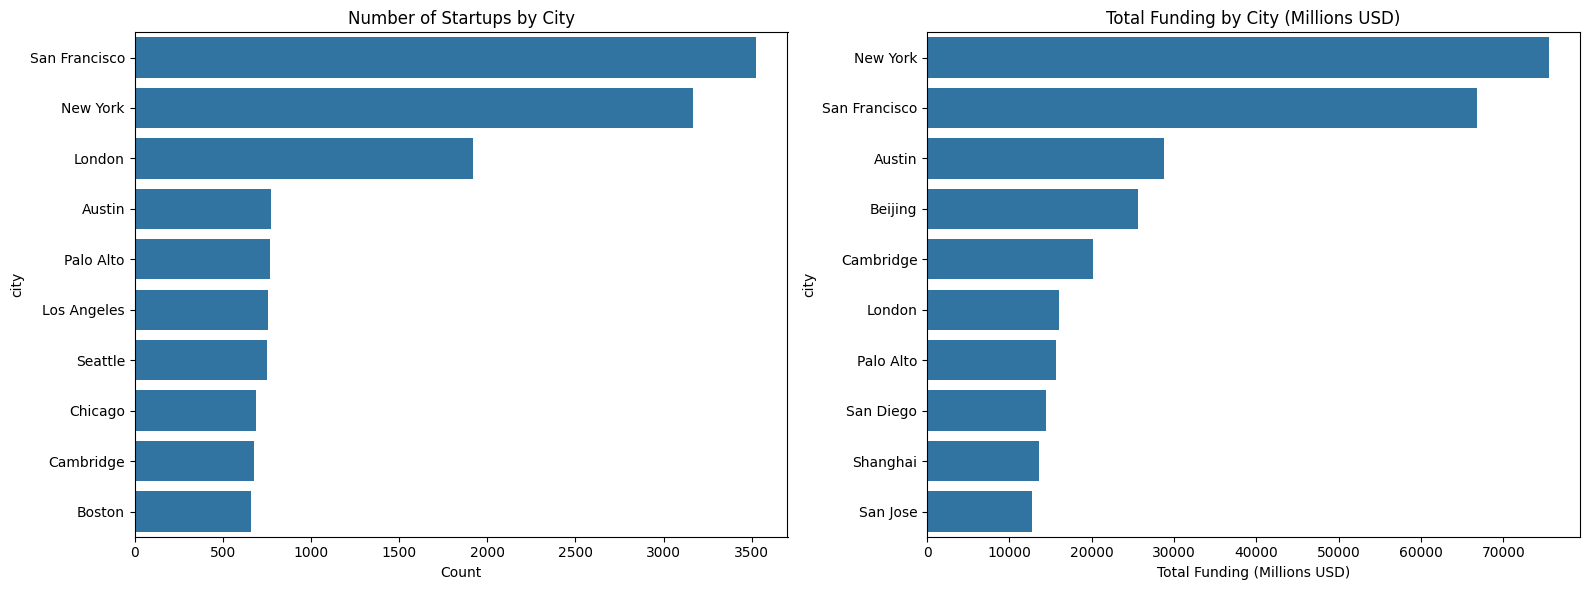

In [43]:
top_cities = df['city'].value_counts().head(10)
city_funding = df.groupby('city')['funding_total_usd'].sum().sort_values(ascending=False).head(10)

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.barplot(x=top_cities.values, y=top_cities.index, ax=ax[0])
ax[0].set_title('Number of Startups by City')
ax[0].set_xlabel('Count')

sns.barplot(x=city_funding.values/1e6, y=city_funding.index, ax=ax[1])
ax[1].set_title('Total Funding by City (Millions USD)')
ax[1].set_xlabel('Total Funding (Millions USD)')
plt.tight_layout()
plt.show()